## **Project title : Time Series Analysis of Daily Female Births in California, 1959**

**Objective:**
The aim of this project is to analyze the daily female birth data from California in 1959, identifying trends, seasonal patterns, and any significant fluctuations over the time. The analysis will explore how birth rates vary throughout the year, highlight any unusual patterns, and provide a visual representation of the data to better understand the demographic trends of the time. The insights derived from this analysis can contribute to a deeper understanding of birth patterns and potentially build a forecasting model.

In [1]:
#import required libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/My Drive/Kaggle projects/Female births')

**Data Loading**

In [22]:
Birth_data=pd.read_csv("daily-total-female-births-CA.csv")
Birth_data.head()

,date,births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


**Data Exploration**

In [17]:
print(Birth_data.shape)
Birth_data.info()

(365, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [18]:
Birth_data.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


In [ ]:
Birth_data.duplicated('date').sum()

0

In [10]:
Birth_data.isna().sum()

,0
date,0
births,0


**Data Preprocessing**

In [24]:
#converting 'date' variable data type from object into date
Birth_data['date'] = pd.to_datetime(Birth_data['date'])

In [28]:
Birth_data.set_index('date', inplace=True)
Birth_data.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


**Exploratory Data Analysis**

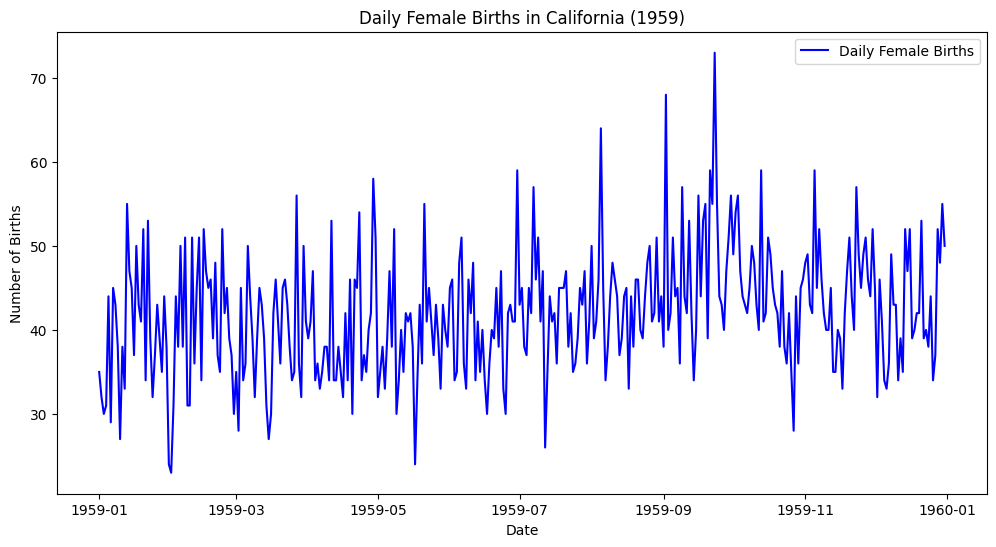

In [29]:
# Daily births over time
plt.figure(figsize=(12, 6))
plt.plot(Birth_data.index, Birth_data['births'], label="Daily Female Births", color="blue")
plt.xlabel("Date")
plt.ylabel("Number of Births")
plt.title("Daily Female Births in California (1959)")
plt.legend()
plt.show()

**Observations:** The data fluctuates over time, showing significant variations in the number of daily female births. Some months have higher peaks, indicating possible seasonality.

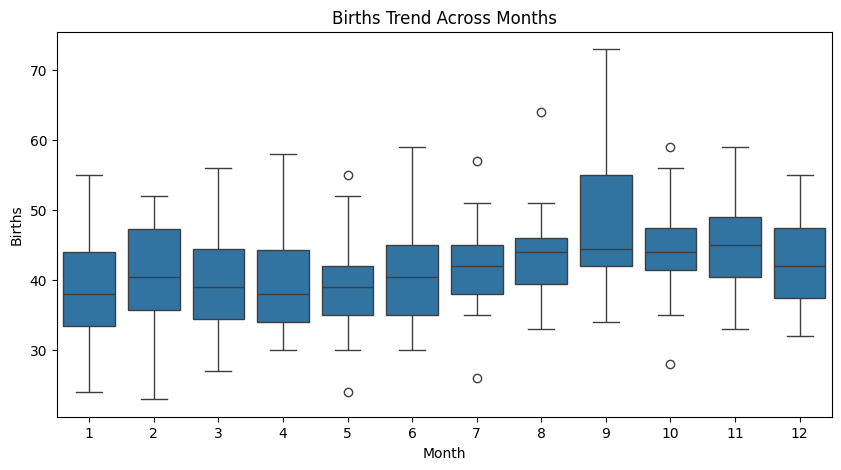

In [35]:
#Boxplot to check seasonal patterns (by month)
Birth_data['month'] = Birth_data.index.month

plt.figure(figsize=(10, 5))
sns.boxplot(x='month', y='births', data=Birth_data)
plt.xlabel("Month")
plt.ylabel("Births")
plt.title("Births Trend Across Months")
plt.show()

**Observations:** Highest births in September, with more outliers and variability. May and June show slightly lower births than other months.
Consistent spread across months, but seasonal effects are visible.

**Time Series Decomposition**

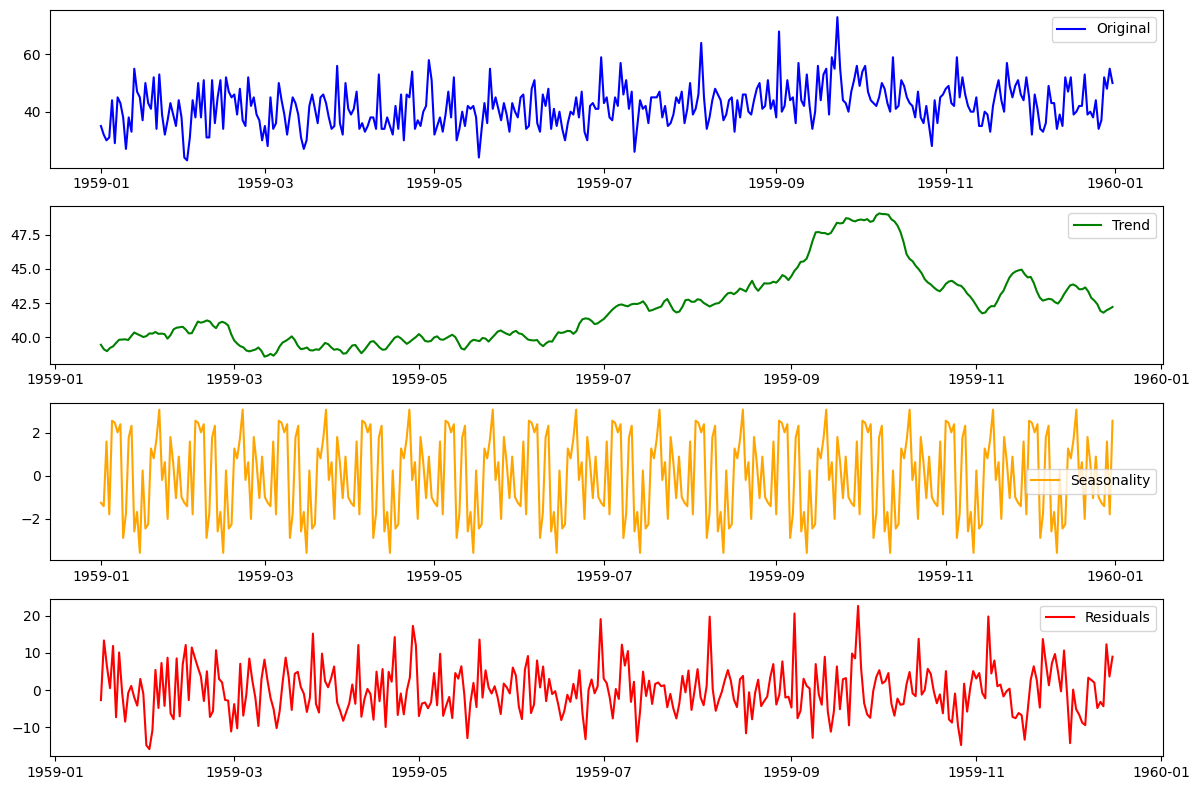

In [37]:
#Decomposing time series into Trend, Seasonality, and Residuals
decomposition = seasonal_decompose(Birth_data['births'], model='additive', period=30)

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(Birth_data['births'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


**Observations:**
- Trend : A slow upward trend is noticeable that means Births increase until Sept-Oct 1959, then decline slightly.
- Seasonality: Clear repeating patterns indicate a strong seasonal cycle.
- Residuals: Randomly distributed, with some spikes but no major patterns.


**Performing ADF test to check whether data is stationary or not**

In [41]:
adf_test = adfuller(Birth_data['births'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("p-value is lessthan 0.05. Data is stationary (Reject H₀)")
else:
    print("p-value is greaterthan 0.05. Data is NOT stationary (Fail to reject H₀)")

ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
p-value is lessthan 0.05 so Data is stationary (Reject H₀)


Here, data is already stationary. So, no need differencing directly we can build models.

**Modelling**

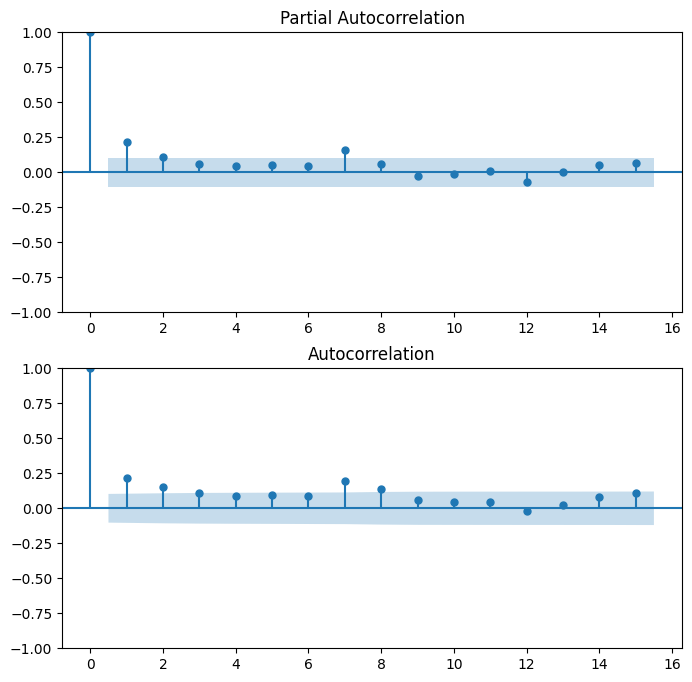

In [74]:
#by using the ACF and PACF plots we can understand p & q values
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
plot_pacf(Birth_data['births'], lags=15, ax=ax[0])
plot_acf(Birth_data['births'], lags=15, ax=ax[1])
plt.show()

**ARIMA Model**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 births   No. Observations:                  365
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1245.097
Date:                Sat, 08 Feb 2025   AIC                           2502.194
Time:                        13:12:01   BIC                           2525.577
Sample:                    01-01-1959   HQIC                          2511.488
                         - 12-31-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7237      0.057    -12.664      0.000      -0.836      -0.612
ar.L2         -0.5426      0.063     -8.550      0.000      -0.667      -0.418
ar.L3         -0.4115      0.068     -6.036      0.0

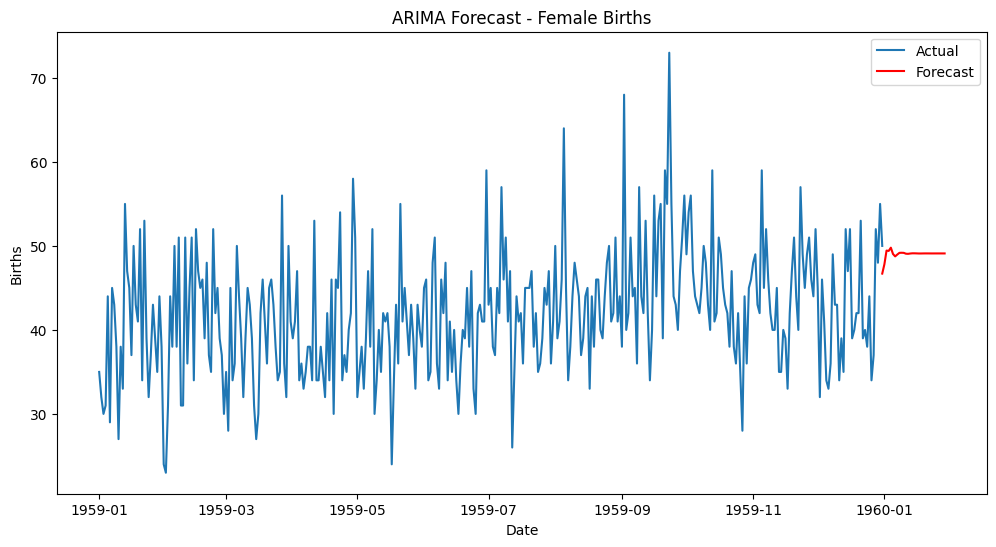

In [86]:
model = ARIMA(Birth_data['births'], order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=30) # forecast for 30days

plt.figure(figsize=(12, 6))
plt.plot(Birth_data.index, Birth_data['births'], label="Actual")
plt.plot(pd.date_range(start=Birth_data.index[-1], periods=30, freq='D'), forecast, label="Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Births")
plt.title("ARIMA Forecast - Female Births")
plt.legend()
plt.show()


In [ ]:
# Extract the last 30 actual values from Birth_data to compare with the forecast
actual_arima = Birth_data['births'].iloc[-30:].values  # Adjust based on forecast length
predicted_arima = forecast.values  # ARIMA forecast output

mse_arima = mean_squared_error(actual_arima, predicted_arima)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(actual_arima, predicted_arima)
mape_arima = np.mean(np.abs((actual_arima - predicted_arima) / actual_arima)) * 100

print(f"Mean Squared Error (MSE): {mse_arima:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima:.2f}")
print(f"Mean Absolute Error (MAE): {mae_arima:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_arima:.2f}%")

**SARIMA Model**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                               births   No. Observations:                  365
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 30)   Log Likelihood               -1181.571
Date:                              Sat, 08 Feb 2025   AIC                           2379.141
Time:                                      13:08:21   BIC                           2409.630
Sample:                                  01-01-1959   HQIC                          2391.298
                                       - 12-31-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7308      0.059    -12.486      0.000      -0.846      -0.616
ar.L2         -0.54

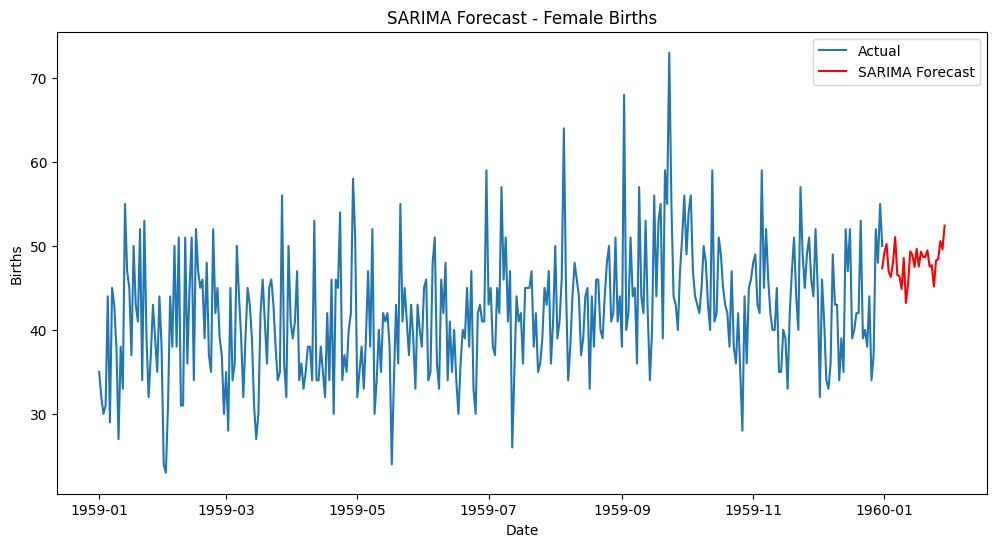

In [85]:
model_sarima = SARIMAX(Birth_data['births'], order=(5,1,0), seasonal_order=(1,1,1,30))
model_fit_sarima = model_sarima.fit()

print(model_fit_sarima.summary())

forecast_sarima = model_fit_sarima.forecast(steps=30) # forecast next 30 days

plt.figure(figsize=(12, 6))
plt.plot(Birth_data.index, Birth_data['births'], label="Actual")
plt.plot(pd.date_range(start=Birth_data.index[-1], periods=30, freq='D'), forecast_sarima, label="SARIMA Forecast", color="red")
plt.xlabel("Date")
plt.ylabel("Births")
plt.title("SARIMA Forecast - Female Births")
plt.legend()
plt.show()


In [88]:
# Extract the last 30 actual values from Birth_data to compare with the forecast
actual = Birth_data['births'].iloc[-30:].values  # Adjust based on forecast length
predicted = forecast_sarima.values  # SARIMA forecast output

mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Squared Error (MSE): 68.19
Root Mean Squared Error (RMSE): 8.26
Mean Absolute Error (MAE): 7.33
Mean Absolute Percentage Error (MAPE): 19.00%
